<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA #ARMA #,AR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.ar_model import AutoReg
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

df = pd.read_csv('./datasets/train.csv')
df.set_index('Date', inplace=True)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
print(df.dtypes)
print('-----')
df.reset_index(inplace=True)
# # Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# # Check the format of the date column
print(df['Date'].dt.strftime('%Y-%m-%d').head())

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object
-----
0    2010-02-05
1    2010-02-12
2    2010-02-19
3    2010-02-26
4    2010-03-05
Name: Date, dtype: object


#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [5]:
df = df.set_index('Date')


KeyError: "None of ['Date'] are in the columns"

In [6]:
df = df[df['Store'] == 1].groupby('Date').sum()[['Weekly_Sales']]
df.head(3)

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

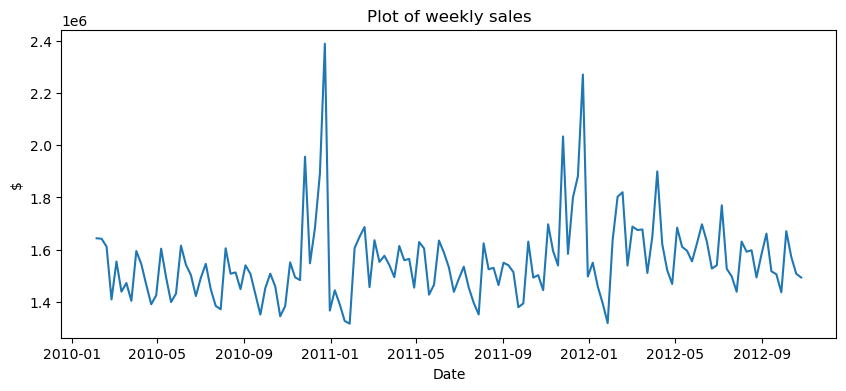

In [7]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Plot of weekly sales')
plt.ylabel('$')
plt.xlabel('Date');

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

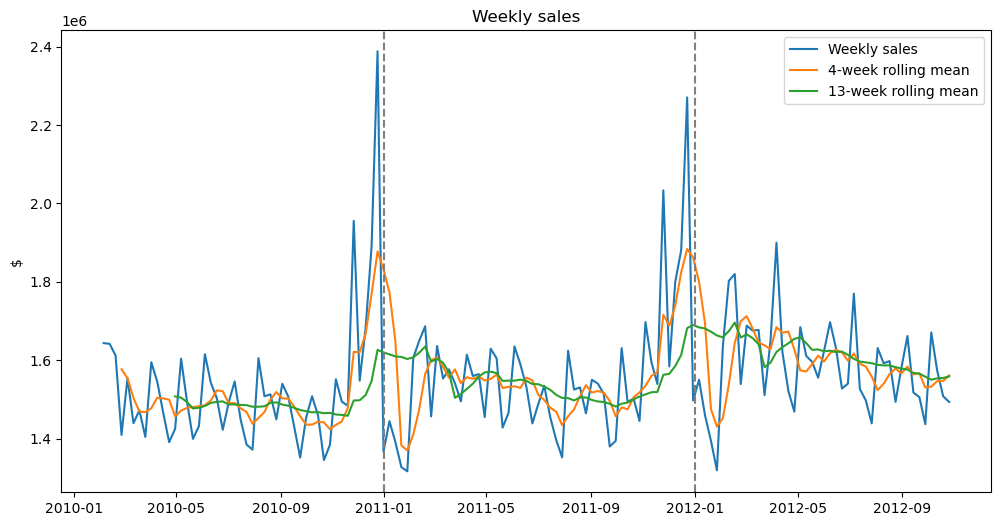

In [9]:

plt.figure(figsize=(12,6))
plt.title('Weekly sales')
plt.ylabel('$')

# time series plotting
plt.plot(df, label='Weekly sales')
plt.plot(df.rolling(4).mean(), label='4-week rolling mean')
plt.plot(df.rolling(13).mean(), label='13-week rolling mean')

# add vertical lines for start of calendar year
plt.axvline(pd.to_datetime('2011-01-01'), linestyle='--', c='gray')
plt.axvline(pd.to_datetime('2012-01-01'), linestyle='--', c='gray')

plt.legend();


**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:* the long term trend of the sales is increasing and since the annual roling mean is decreasing in fluctuation, the long term trend is stabilising.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [32]:
autocorrelation = df['Weekly_Sales'].autocorr(lag=1)
print('1 week: ', autocorrelation)
autocorrelation2 = df['Weekly_Sales'].autocorr(lag=3)
print('2 week: ', autocorrelation2)
autocorrelation3 = df['Weekly_Sales'].autocorr(lag=52)
print('1 year: ', autocorrelation3)

1 week:  0.9451385765676783
2 week:  0.9172176564739466
1 year:  0.7509053803681355


**3b. What can you say about the series based on these autocorrelations?**

Answer: strong positive autocorrelation at short lags, suggesting that the sereis has a strong weekly pattern. decline in autocorrelation over time suggests that while the immediate past is a good predictor of the near future, the strenght of this rleationship decreases over time. but the autocorrelation is still relatively high at 1 year, suggesting there might be a seasonal component to the series.

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

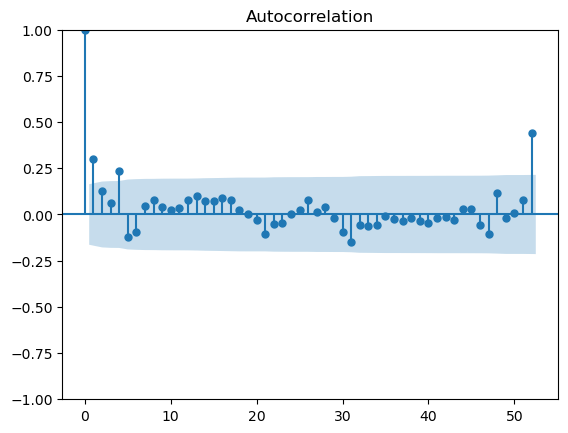

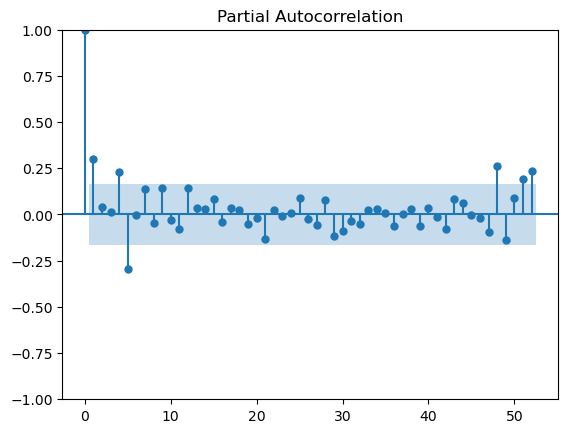

In [11]:
plot_acf(df, lags=52)
plot_pacf(df, lags=52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer:

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: from PACF where lags alternate in sign, suggests arima model is appropriate. 

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, shuffle=False)

In [54]:
df.info

<bound method DataFrame.info of             Store  Dept  Weekly_Sales  IsHoliday
Date                                            
2010-02-05      1     1      24924.50      False
2010-02-12      1     1      46039.49       True
2010-02-19      1     1      41595.55      False
2010-02-26      1     1      19403.54      False
2010-03-05      1     1      21827.90      False
...           ...   ...           ...        ...
2012-09-28     45    98        508.37      False
2012-10-05     45    98        628.10      False
2012-10-12     45    98       1061.02      False
2012-10-19     45    98        760.01      False
2012-10-26     45    98       1076.80      False

[421570 rows x 4 columns]>

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [14]:
ar = ARIMA(endog=train, order=(1,0,0)).fit()

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [15]:
train_preds = ar.predict(start=train.index[0], end=train.index[-1])
test_preds = ar.predict(start=test.index[0], end=test.index[-1])

In [16]:
mean_squared_error(test, test_preds)

11108604491.056707

**6c. How effective do you think this `AR(1)` model is?**

Answer:

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

In [31]:
def plot_preds(train, test, train_preds, test_preds, title=None, truncate=False):
    
   
    plt.figure(figsize=(12,4))

    plt.plot(train, label='training data')
    plt.plot(test, label='testing data')
    
    if truncate:
        plt.plot(train_preds.iloc[truncate:], linestyle='--', label='training preds')
    else:
        plt.plot(train_preds, linestyle='--', label='training preds')
    plt.plot(test_preds, linestyle='--', label='testing preds')

    plt.title('Walmart weekly sales')
    if title:
        plt.suptitle(title)
    plt.legend();

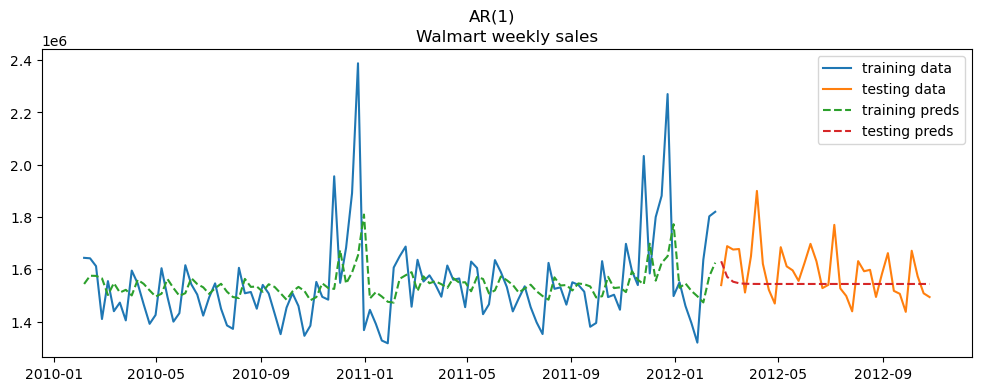

In [18]:
plot_preds(train, test, train_preds, test_preds, 'AR(1)')

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

**8b. How did your results change?**

Answer:

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [19]:
arma = ARIMA(endog=train, order=(2,0,2)).fit()

In [20]:
train_preds = arma.predict(start=train.index[0], end=train.index[-1])
test_preds = arma.predict(start=test.index[0], end=test.index[-1])
mean_squared_error(test, test_preds)

11047421679.205063

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer: the mse decreased slightly

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [22]:
adfuller(df)

(-5.102186145192292,
 1.3877788330759122e-05,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 3412.7325502876756)

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: there is insufficient evidence to that data is non-stationary

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [23]:
df['Weekly_Sales_diff1'] = df['Weekly_Sales'].diff(periods=1)
df['Weekly_Sales_diff2'] = df['Weekly_Sales'].diff(periods=2)
df['Weekly_Sales_diff3'] = df['Weekly_Sales'].diff(periods=3)
df['Weekly_Sales_diff4'] = df['Weekly_Sales'].diff(periods=4)

**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [25]:
adf_result = adfuller(df['Weekly_Sales'])

# Print the ADF test result
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -5.102186145192292
p-value: 1.3877788330759122e-05
Critical Values: {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}


sufficient evidence to reject null hypothesis


**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [27]:
arima = ARIMA(endog=train, order=(2,2,2)).fit()

In [28]:
train_preds = arima.predict(start=train.index[0], end=train.index[-1])
test_preds = arima.predict(start=test.index[0], end=test.index[-1])
mean_squared_error(test, test_preds)

316369694746.8555

**11b. Interpret the results from the last answer.**


Answer:

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55766D+00    |proj g|=  8.43801D+00


 This problem is unconstrained.



At iterate    5    f=  6.42883D+00    |proj g|=  6.54898D-02

At iterate   10    f=  6.42835D+00    |proj g|=  1.95422D-01

At iterate   15    f=  6.42819D+00    |proj g|=  2.17700D-01

At iterate   20    f=  6.42335D+00    |proj g|=  1.32941D+00

At iterate   25    f=  6.40767D+00    |proj g|=  2.76856D-01

At iterate   30    f=  6.40227D+00    |proj g|=  8.11939D-02

At iterate   35    f=  6.40036D+00    |proj g|=  3.56720D-02

At iterate   40    f=  6.39911D+00    |proj g|=  1.86231D-02

At iterate   45    f=  6.39748D+00    |proj g|=  8.59407D-03

At iterate   50    f=  6.39071D+00    |proj g|=  4.34920D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

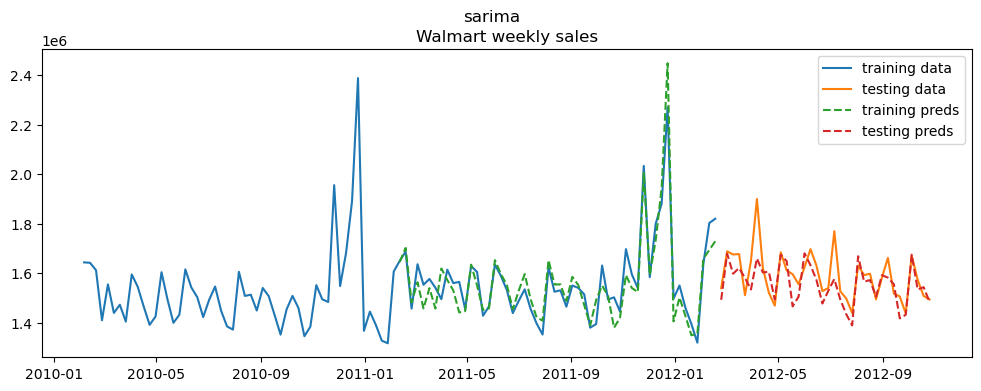

In [32]:
sarima = SARIMAX(train, order=(2,0,2), seasonal_order=(1,1,1,52)).fit()

train_preds = sarima.predict(start=train.index[0], end=train.index[-1])
test_preds = sarima.predict(start=test.index[0], end=test.index[-1])

plot_preds(train, test, train_preds, test_preds, 'sarima', truncate=53)

**12b. How did your best SARIMAX model perform?**

Answer:

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: 

**13c. How might you improve it?**

Answer:

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: